# Training on Large Datasets on Palmetto with Dask

This example is based on the Notebooks provided at:

https://github.com/dask/dask-examples

In this notebook,
we'll use [https://dask-ml.readthedocs.io/en/latest/](Dask-ML)
to perform K-means clustering on a large-ish dataset.

Most estimators in scikit-learn are designed to
work with NumPy arrays or scipy sparse matricies.
These data structures must fit in the RAM on a single machine.

Estimators implemented in Dask-ML work well with Dask Arrays and DataFrames.
This can be much larger than a single machine's RAM.
They can be distributed in memory on a cluster of machines.

We'll run `scikit-learn`'s KMeans on a single node (24 cores) of Palmetto cluster
and compare the runtime with running Dask-ML's KMeans on **four** nodes (a total of 96 cores).

## Training on a single node (scikit-learn)

We use the `make_blobs` function below to create a dataset of 100000000 points that we'll cluster with KMeans.

In [37]:
import sklearn
import sklearn.datasets
import sklearn.cluster

N = 100000000
X, y = sklearn.datasets.make_blobs(n_samples=N, random_state=0, centers=3)

Next, we use `scikit-learn`'s KMeans algorithm to cluster the points. Note that algorithm itself is sequential, but can be parallelized on a single machine over the parameter `n_init`:

In [38]:
km = sklearn.cluster.KMeans(n_clusters=3, n_init=1)

In [39]:
import time
t1 = time.time()
km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

Clustering took 116.80316543579102 seconds.


Below, we check the locations of the centroids and visualize the results of the clustering:

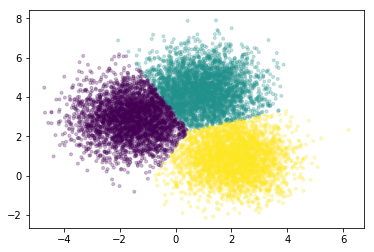

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [41]:
km.cluster_centers_

array([[-1.59657324,  2.88873064],
       [ 1.02561361,  4.37128981],
       [ 2.06665787,  0.87196219]])

## Distributed training (Dask-ML)

Before using Dask-ML, you should start a Dask cluster by running `start-dask-cluster` on the terminal. Then, run the cell below to connect to the Dask cluster.

In [42]:
from dask.distributed import Client
e = Client(scheduler_file='/home/atrikut/dask-scheduler.json')
e

Client Scheduler: tcp://10.125.8.53:8088 Dashboard: http://10.125.8.53:8787/status,Cluster Workers: 4 Cores: 64 Memory: 268.97 GB


In [43]:
import dask_ml.datasets
import dask_ml.cluster
import dask.array as da

Below, we convert the NumPy arrays `X` and `y` into *Dask arrays* using the `da.from_array()` function.

In [45]:
chunk_size = 5000000
X, y = da.from_array(X, chunks=(chunk_size,-1)), da.from_array(y, chunks=(chunk_size,))

# X, y = dask_ml.datasets.make_blobs(n_samples=100000000,
#                                    chunks=5000000,
#                                    random_state=0,
#                                    centers=3)
X = X.persist()
y = y.persist()

The `KMeans` implementation provided by Dask-ML differs from the `scikit-learn` implementation in a few respects:

* The default initializer for Dask-ML's KMeans is `k-means||`, compared to `k-means++` from scikit-learn. This is the algorithm described in *Scalable K-Means++ (2012)*.

* Dask-ML's KMeans can work effectively 

In [46]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=1, oversampling_factor=10)

In [47]:
import time
t1 = time.time()
result = km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

/home/atrikut/.conda/envs/dask_env/lib/python3.7/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Clustering took 30.93523144721985 seconds.


In [48]:
%matplotlib inline

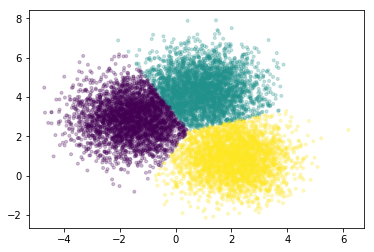

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [50]:
km.cluster_centers_

array([[-1.59881994,  2.88705989],
       [ 1.02330525,  4.36873448],
       [ 2.06742387,  0.8708029 ]])